# Regresión en Redes Neuronales Arficiales

Durante la asignatura hemos visto distintos de solucionar problemas de regresión, de hecho en la primera clase dijimos: "A lo largo del curso y la asignatura veremos que un mismo problema se puede solucionar de distintas formas"

Vamos a experimentar con varios tipos de redes neuronales para predecir el valor de una acción. Vamos a trabajar con la acción de Pharmamar para lo cual necesitamos su histórico desde el 1-1-2011

https://es.finance.yahoo.com/quote/AAPL/history?p=AAPL

En aules podéis decargaros el archivo: PHM.MC.csv

El objetivo de esta práctica es predecir el precio máximo de la acción para el día siguiente a uno dado.

## **1. Preparación de datos**

In [ ]:
import numpy as np
np.random.seed(4)
import pandas as pd
import plotly 
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
df = pd.read_csv('PHM.MC.csv', index_col='Date', parse_dates=['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2862 entries, 2011-01-03 to 2022-03-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2861 non-null   float64
 1   High       2861 non-null   float64
 2   Low        2861 non-null   float64
 3   Close      2861 non-null   float64
 4   Adj Close  2861 non-null   float64
 5   Volume     2861 non-null   float64
dtypes: float64(6)
memory usage: 156.5 KB


In [ ]:
df.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [ ]:
# Hay una fila con nulos
df = df.dropna()
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,33.600136,34.560139,32.400127,33.720135,33.336208,24366.0
2011-01-04,33.600136,34.140137,33.000134,33.120132,32.743038,21499.0
2011-01-05,33.540134,33.540134,32.700130,33.000134,32.624405,11077.0
2011-01-06,33.420132,33.420132,31.920128,32.220127,31.853281,8829.0
2011-01-07,32.040127,32.580132,31.200125,31.200125,30.844891,25342.0


## **2. Neural Network FF (Feed Fordward)**

El objetivo el predecir el precio máximo de la acción para el día siguiente a uno dado

### **2.1 Series temporales**

El precio de una acción depende de la variable tiempo (serie temporal)

In [ ]:
# Nos crearemos un DataFrame con la fecha, el precio máximo para esa fecha y el precio máximo del dia siguiente
df2 = df.drop(['Open', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
df3 = df2
df3=df3.shift(periods=-1)
df2['HighNextDay'] = df3['High']
df2 = df2.dropna()
df2

,High,HighNextDay
Date,,
2011-01-03,34.560139,34.140137
2011-01-04,34.140137,33.540134
2011-01-05,33.540134,33.420132
2011-01-06,33.420132,32.580132
2011-01-07,32.580132,31.560125
...,...,...
2022-03-01,60.200001,61.459999
2022-03-02,61.459999,62.759998
2022-03-03,62.759998,58.220001


In [ ]:
# Vamos a coger del 2011 al 2020 para entrenamiento y los datos del 2022 para testear
train = df2[:'2020'].iloc[:,:]
test = df2['2021':].iloc[:,:]

<function matplotlib.pyplot.show(close=None, block=None)>

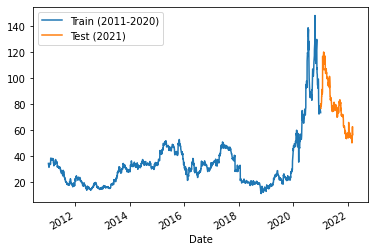

In [ ]:
train['High'].plot(legend=True)
test['High'].plot(legend=True)
plt.legend(['Train (2011-2020)', 'Test (2021)'])
plt.show

### **2.2 Normalización**

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))

X_train = sc.fit_transform(train['High'].values.reshape(-1,1))
y_train = sc.fit_transform(train['HighNextDay'].values.reshape(-1,1))

### **2.3 Modelo**

In [ ]:
# Specify the structure of a Neural Network
model = Sequential(name="Model-with-One-Input") 
model.add(Input(shape=(1,), name='Input-Layer'))
model.add(Dense(2, activation='softplus', name='Hidden-Layer')) # Hidden Layer, softplus(x) = log(exp(x) + 1)
model.add(Dense(1, activation='sigmoid', name='Output-Layer')) # Output Layer, sigmoid(x) = 1 / (1 + exp(-x))


# Compile keras model
model.compile(optimizer='adam', loss='binary_crossentropy')

# Fit keras model on the dataset
model.fit(X_train, y_train, batch_size=10, epochs=3)

# Model Performance Summary
print("")
print('-------------------- Model Summary --------------------')
model.summary()
print("")
print('-------------------- Weights and Biases --------------------')
for layer in model.layers:
    print("Layer: ", layer.name) # print layer name
    print("  --Kernels (Weights): ", layer.get_weights()[0]) # weights
    print("  --Biases: ", layer.get_weights()[1]) # biases

Epoch 1/3
256/256 [==============================] - 1s 2ms/step - loss: 0.5456
Epoch 2/3
256/256 [==============================] - 1s 2ms/step - loss: 0.4705
Epoch 3/3
256/256 [==============================] - 1s 2ms/step - loss: 0.4521

-------------------- Model Summary --------------------
Model: "Model-with-One-Input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer (Dense)        (None, 2)                 4         
                                                                 
 Output-Layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________

-------------------- Weights and Biases --------------------
Layer:  Hidden-Layer
  --Kernels (Weights):  [[-0.35787934  0.18107468]]
  --Biases:  [0.

### **2.4 Predicción**

In [ ]:
X_test = sc.fit_transform(test['High'].values.reshape(-1,1))
y_test = sc.fit_transform(test['HighNextDay'].values.reshape(-1,1))

# Realizamos la prediccion y aplicamos normalización inversa para que esté en escala real
y_predicted = model.predict(X_test)
y_predicted = sc.inverse_transform(y_predicted)


10/10 [==============================] - 0s 2ms/step


### **2.5 Visualizar resultados**

<ipython-input-37-cfb6259ec4ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['HighPredicted'] = y_predicted


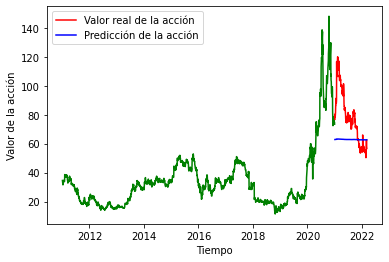

In [ ]:
test['HighPredicted'] = y_predicted
plt.plot(train['High'], color='green')
plt.plot(test['High'], color='red', label='Valor real de la acción')
plt.plot(test['HighPredicted'], color='blue', label='Predicción de la acción')
plt.xlabel('Tiempo')
plt.ylabel('Valor de la acción')
plt.legend()
plt.show()

En la gráfica podemos apreciar que no ha realizado predicción. La linea azul.

## **3. Red neuronal optimizando parámetros**

Podemos ajustar fácilmente los datos de regresión con el modelo secuencial de Keras y predecir los datos de prueba. En esta parte, aprenderemos brevemente cómo ajustar los datos de regresión con la **KerasRegressor** .

In [ ]:
# Nos crearemos un DataFrame con la fecha, el precio máximo para esa fecha y el precio máximo del dia siguiente
df2 = df.drop(['Open', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
df3 = df2
df3=df3.shift(periods=-1)
df2['HighNextDay'] = df3['High']
df2 = df2.dropna()

In [ ]:
# Vamos a coger del 2011 al 2020 para entrenamiento y los datos del 2022 para testear
train = df2[:'2020'].iloc[:,:]
test = df2['2021':].iloc[:,:]

In [ ]:
# Normalizamos
sc = MinMaxScaler(feature_range=(0,1))

X_train = sc.fit_transform(train['High'].values.reshape(-1,1))
y_train = sc.fit_transform(train['HighNextDay'].values.reshape(-1,1))

### **3.1 Crear modelo**

En este punto se pide realizar una función en Python que se llame create_model, tiene que tener 4 variables de entrada:


*   lyrs: Vector con las capas.
*   act: Función de activación.
*   opt: Optimizador.
*   dr: Dropout.

A continuación tenéis como debe de quedar la cabecera de la función:

*   def create_model(lyrs=[1], act='linear', opt='Adam', dr=0.0):

La última capa debe de ser la siguiente:

*   model.add(Dense(1, activation='relu'))  


Ayuda: La primera y última capa son fijas, lo que tenemos que crear es un bucle con el número de capas ocultas que le pasamos a la función.
Ejemplo de lo que podemos recibir en lyrs
*   lyrs = [[8],[10],[10,5],[12,6],[12,8,4]]







### **3.2 Entrenar modelo**

En este punto tenéis que entrenar el modelo con los siguientes hiperparámentros:


*   epochs=100
*   batch_size=32
*   validation_split=0.2
*   verbose=0



### **3.3 Optimizando hiperparámetros**

#### 3.3.1 Batch_size y epochs

Vamos a utilizar en este punto KerasRegressor. Para ellos vamos a probar con los siguientes hiperpáramentros:

*   batch_size = [16, 32, 64]
*   epochs = [50, 100]



#### **3.3.2 Optimizar algoritmo**

En este punto ya sabemos las mejores epochs y batch_size para nuestro modelo. Ahora vamos a experimentar con los siguientes optimizadores:

    ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam']

(Nadam es una extensión de la versión de Adam del descenso de gradiente que incorpora Nesterov momentum)


#### **3.3.4 Neuronas ocultas**

En este punto vamos a experimentar con las capas que tiene que tener nuestro modelo. Las capas que se proponen son las siguientes:

layers = [[8],[10],[10,5],[12,6],[12,8,4]]


#### **3.3.5 Dropout**

Vamos a experimentar como se comporta nuestra red con los siguientes dropout:
[0.0, 0.01, 0.05, 0.1, 0.2, 0.5]

### **3.4 Modelo final**

En esta parte teneis que utilizar la función create_model con las capas, dropout y optimizador óptimos.

### **3.5 Entrenando modelo final**

En esta parte entrenaremos el módelo con las epochs y batch_size óptimas. Con un porcentaje 80/20 entrenamiento y validación.

### **3.6 Predicciones**

Realizamos inferencia con los datos de test.

### **3.7 Visualizando modelo final**

Visualizamos los resultados utilizando la gráfica del punto 2.5

## **4 .LSTM (Long Short-Term Memory)**

Las LSTM son un tipo especial de redes recurrentes. La característica principal de las redes recurrentes es que la información puede persistir introduciendo bucles en el diagrama de la red, por lo que, básicamente, pueden «recordar» estados previos y utilizar esta información para decidir cuál será el siguiente. Esta característica las hace muy adecuadas para manejar series cronológicas.

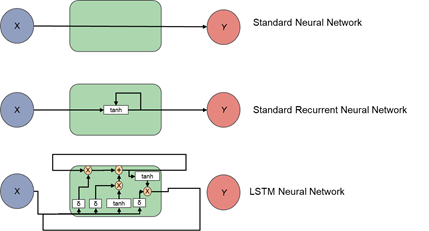



En A), Y depende únicamente de X. En B), Y depende de X y del valor anterior de Y. En C), la lógica es más compleja para mejorar el efecto de instancias anteriores de Y (y, por consiguiente, de X).

In [ ]:
# Vamos a coger del 2011 al 2021 para entrenamiento y los datos a partir de 2022 para testear
# Para poder introducir los datos en una red neuronal hay que transformarlos, ya que solo funciona con arrays

train = df[:'2020'].iloc[:,1:2]
test = df['2021':].iloc[:,1:2]

In [ ]:
# Tiene que ser un vector columna
train.shape

(2558, 1)

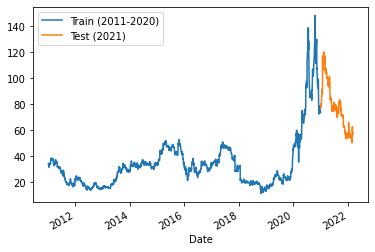

In [ ]:
train['High'].plot(legend=True)
test['High'].plot(legend=True)
plt.legend(['Train (2011-2020)', 'Test (2021)'])
plt.show()

### **4.1 Normalización**

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)

### **4.2 Estructura datos entrada**

In [ ]:
# Hay que crear una estructura de datos para indicarle a la red lo que tiene que recordar 
# y poder hacer una predección en base a datos anteriores
X_train = []
y_train = []

# Estructura de datos con 60 pasos y un valor de salida
# 60 timesteps significa que para un día dado la red es capaz de mirar los 60 días anteriores:
# 60 precios anteriores al día actual y en base a esa información predice el precio de la acción 
for i in range(60,len(train_scaled)):
    # X: para cada día hacemos un bloque correspondiente al precio de los 60 días anteriores
    X_train.append(train_scaled[i-60:i,0])
    # Y: el precio del día
    y_train.append(train_scaled[i,0])

# Tenemos una matriz donde cada fila contiene 60 columnas correspondientes a los 60 días anteriores
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train para que se ajuste al modelo en Keras
# añadiendo una nueva dimensión 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2498, 60, 1)

### **4.3 Modelo**

Vamos a creamos un modelo secuencial al que iremos añadiendo capas, que pueden ser:

*   Dense: Capa de neuronas artificiales
*   LSTM: Capa de neuronas con capacidad de memoria
*   Dropout: Es una técnica de regularización que elimina conexiones neuronales para evitar el sobreajuste, de esta forma se evita que el algoritmo memorice los datos en vez de aprender de ellos. 

Antes de crear la Red LSTM debemos reajustar los sets que acabamos de obtener, para indicar que cada ejemplo de entrenamiento a la entrada del modelo será un vector de 60x1.

Para el caso de cada una de las salidas (almacenadas en y_train) debemos simplemente especificar que su tamaño será igual a 1, que corresponde al único valor predicho por la red.

### **4.4 Compilación**

*   El optimizador se encarga de optimizar y actualizar los pesos de la red. Usaremos el algoritmo adam que es el que mejores resultados nos aporta.
*   loss: Cuando la red hace una predicción coge el valor real y lo compará con la predicción. Para calcular el error de predicción, se utilizará el método error cuadrático medio. 

### **4.5 Entrenamiento**

*   epochs: Especificamos las veces que la red propagara el error hacia atrás para aprender y hacer mejores predicciones. Es la cantidad de veces que la red realizará una predicción y propagara hacia atrás el error, para aprender de él y hacer mejores predicciones
*   batch_size: Para este proceso de predicción, corrección y propagación hacia atrás, no lo haremos con un solo bloque de datos, si no de 32. Si no el entrenamiento sería demasiado pesado para la red, el tener que actualizar los pesos a cada dato. Vamos actualizando los pesos con bloques de datos.

### **4.6 Predicciones**

Hay que preparar los datos como en el caso de train, esto es, hacemos bloques de 60 días para predecir el valor de la acción en el siguiente día.

In [ ]:
test_scaled = sc.fit_transform(test)

X_test = []
for i in range(60,len(test_scaled)):
    X_test.append(test_scaled[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# Realizamos la prediccion y aplicamos normalización inversa para que esté en escala real
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

prediccion

8/8 [==============================] - 2s 38ms/step


array([[100.7755  ],
       [100.407005],
       [100.88563 ],
       [100.61131 ],
       [100.897675],
       [100.77895 ],
       [100.04833 ],
       [ 99.046616],
       [ 98.6497  ],
       [ 96.30422 ],
       [ 95.886406],
       [ 96.03753 ],
       [ 97.36973 ],
       [ 97.58068 ],
       [ 96.88096 ],
       [ 95.454346],
       [ 96.003456],
       [ 96.50761 ],
       [ 98.11439 ],
       [ 96.89009 ],
       [ 95.936615],
       [ 94.572716],
       [ 99.63315 ],
       [101.687225],
       [ 99.07344 ],
       [ 94.75329 ],
       [ 91.43988 ],
       [ 88.920074],
       [ 87.41653 ],
       [ 87.095535],
       [ 85.91666 ],
       [ 85.49989 ],
       [ 84.751656],
       [ 84.90993 ],
       [ 85.57863 ],
       [ 86.13054 ],
       [ 85.75417 ],
       [ 85.54014 ],
       [ 85.11436 ],
       [ 83.755615],
       [ 82.5969  ],
       [ 82.22797 ],
       [ 81.20993 ],
       [ 79.23838 ],
       [ 78.24793 ],
       [ 78.0731  ],
       [ 76.72194 ],
       [ 76.3

### **4.7 Visualización del resultado**

## **Conclusiones de la prácticas**

En esta práctica hemos podido experimentar con una herramienta como KerasRegressor, nos permite automatizar la elección de hiperparámetros de un modelo. Por otro lado, hemos podido ver lo bien que se comportan las Redes Neuronales Recurrentes en series temporales, sin optimizar la red hemos obtenido mejores resultado que una red neuronal sólo con capas Dense. Esto es debido a que tienen una memoria interna donde se almacena un hidden state, en esta práctica hemos utilizado un tipo que se denomina LSTM, estas tienen un nuevo estado que se denomina Cell state, que ayuda a que no ocurran estos dos grandes problemas de este tipo de neuronas:
*  Vanishing gradients: los gradientes “se desvanecen” y van a 0.
*  Exploding gradients: los gradientes “explotan” y se hacen muy grandes.
